# Preprocessing and Preparation of the Data

Importing Neccessary Libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib as j
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score



ModuleNotFoundError: No module named 'pandas'

Reading and Examining Data from data folder

In [ ]:
df=pd.read_csv('../data/raw/customer_churn_large_dataset.csv')
df.head(10)

CustomerID         Name  Age  Gender     Location  \
0           1   Customer_1   63    Male  Los Angeles   
1           2   Customer_2   62  Female     New York   
2           3   Customer_3   24  Female  Los Angeles   
3           4   Customer_4   36  Female        Miami   
4           5   Customer_5   46  Female        Miami   
5           6   Customer_6   67    Male     New York   
6           7   Customer_7   30  Female      Chicago   
7           8   Customer_8   67  Female        Miami   
8           9   Customer_9   20  Female        Miami   
9          10  Customer_10   53  Female  Los Angeles   

   Subscription_Length_Months  Monthly_Bill  Total_Usage_GB  Churn  
0                          17         73.36             236      0  
1                           1         48.76             172      0  
2                           5         85.47             460      0  
3                           3         97.94             297      1  
4                          19         58.14             266      0  
5                          15         82.65             456      1  
6                           3         73.79             269      0  
7                           1         97.70             396      1  
8                          10         42.45             150      1  
9                          12         64.49             383      1

In [ ]:
df.shape

(100000, 9)

Checking for missing values and duplicated rows

In [ ]:
print("The number of missing values are:")
print(df.isna().sum())
print("Total number of duplicated rows:", df.duplicated().sum())

The number of missing values are:
CustomerID                    0
Name                          0
Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64
Total number of duplicated rows: 0


Insights:

      There seems to be no duplicated rows or missing values in any of the columns, so we can say our data is already in a consistent form.

Dropping Low Impact Predictors like CustomerID and Name

In [ ]:
df = df.drop(["CustomerID", "Name"], axis=1)
df.head(5)

Age  Gender     Location  Subscription_Length_Months  Monthly_Bill  \
0   63    Male  Los Angeles                          17         73.36   
1   62  Female     New York                           1         48.76   
2   24  Female  Los Angeles                           5         85.47   
3   36  Female        Miami                           3         97.94   
4   46  Female        Miami                          19         58.14   

   Total_Usage_GB  Churn  
0             236      0  
1             172      0  
2             460      0  
3             297      1  
4             266      0

Checking for potential categorical variables

In [ ]:
# Location having 5 distinct values hence it qualifies as a categorical variable
df["Location"].value_counts()


Houston        20157
Los Angeles    20041
Miami          20031
Chicago        19958
New York       19813
Name: Location, dtype: int64

In [ ]:
# Gender having two distinct values is considered a categorical variable
df["Gender"].value_counts()

Female    50216
Male      49784
Name: Gender, dtype: int64

In [ ]:
# Susbscription_Length_Months has alot of distinct values so we can distribute them into three main categories being Short Term, Medium Term, and Long Term
# We will first try building our models with numeric values and later try to categorize them if need be
df["Subscription_Length_Months"].value_counts().sort_index()

1     4247
2     4228
3     4136
4     4098
5     4171
6     4184
7     4211
8     4106
9     4134
10    4151
11    4200
12    4155
13    4154
14    4213
15    4122
16    4229
17    4064
18    4171
19    4106
20    4303
21    4154
22    4267
23    4083
24    4113
Name: Subscription_Length_Months, dtype: int64

Changing Categorical Variables Gender and Location to numeric values

In [ ]:
# Gender will be changed into 1 or 0 from 'Male' or 'Female'
gender_mapping = {'Female': 0, 'Male': 1}
df['Gender_encoded'] = df['Gender'].map(gender_mapping)

# Location having 5 values it will be encoded to numeric values using sklearn.preprocessing LabelEncoder function
label_encoder = LabelEncoder()
df['Location_encoded'] = label_encoder.fit_transform(df['Location'])

# We shall now remove the Orignal Gender and Location columns from the dataframe

df.drop(columns=['Location', 'Gender'], inplace=True) 

'''
In Gender "Male" has been mapped to 1 and "Female" has been mapped to 0 
In Location the values have been mapped as follows: 
Chicago : 0
Houston : 1
Los Angeles : 2
Miami : 3
New York: 4
'''
df.head()

Age  Subscription_Length_Months  Monthly_Bill  Total_Usage_GB  Churn  \
0   63                          17         73.36             236      0   
1   62                           1         48.76             172      0   
2   24                           5         85.47             460      0   
3   36                           3         97.94             297      1   
4   46                          19         58.14             266      0   

   Gender_encoded  Location_encoded  
0               1                 2  
1               0                 4  
2               0                 2  
3               0                 3  
4               0                 3

Defining columns into a list with respect to their type

In [ ]:
# Following are the continuos variables with arbitary numreic values:  
list_x_continous_variables = ["Age", "Subscription_Length_Months", "Monthly_Bill","Total_Usage_GB"]

# Following are the categorical variables with processed values:
list_x_discrete_variables = ["Gender_encoded", "Location_encoded"]

# Following is the target variable:
list_y_target_variable = ["Churn"]

In [ ]:
def plot_distribution(df_input_for_plot, list_columns_to_plot):
  for s_column_to_plot in list_columns_to_plot:
    df_grouped_plot = df_input_for_plot.groupby([s_column_to_plot]).size().reset_index(name= 'count')
    plt.figure(figsize=(3,1.2))
    plt.title(s_column_to_plot)
    sns.barplot(df_grouped_plot, x = s_column_to_plot, y = 'count')


In [ ]:

def plot_distribution_hue(df_input_for_plot, list_columns_to_plot, s_target_variable):
  for s_column_to_plot in list_columns_to_plot:
    df_grouped_plot = df_input_for_plot.groupby([s_column_to_plot, s_target_variable]).size().reset_index(name= 'count')
    plt.figure(figsize=(5,2))
    plt.title(s_column_to_plot)
    sns.barplot(df_grouped_plot, x = s_column_to_plot, y = 'count', hue = s_target_variable)

# Function that takes dataframe and columns as input to plot them in bar graph. This function will called several time for insights generation and understand features.
def histogram_distribution(df_input_for_plot, list_columns_to_plot, s_target_variable):
  for s_column_to_plot in list_columns_to_plot:
    df_grouped_plot = df_input_for_plot.groupby([s_column_to_plot, s_target_variable]).size().reset_index(name= 'count')
    plt.figure(figsize=(5,2))
    plt.title(s_column_to_plot)
    sns.histplot(df_grouped_plot, x = s_column_to_plot, hue = s_target_variable, multiple="dodge", shrink=.8, bins = 7)

Checking for Class Imbalance

   Churn  count
0      0  50221
1      1  49779


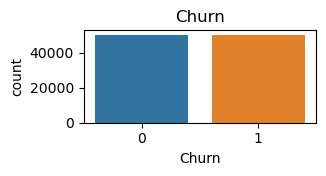

In [ ]:
plot_distribution(df, list_y_target_variable)
print (df.groupby(list_y_target_variable).size().reset_index(name= 'count'))

# There is a very slight imbalance in the dataset so we will not sample our data

In [ ]:
# We will also rearrange our data to have Churn column towards the end for better readability
columns = df.columns.tolist()
columns.remove("Churn")
columns.append("Churn")
df = df[columns]
df.head()


Age  Subscription_Length_Months  Monthly_Bill  Total_Usage_GB  \
0   63                          17         73.36             236   
1   62                           1         48.76             172   
2   24                           5         85.47             460   
3   36                           3         97.94             297   
4   46                          19         58.14             266   

   Gender_encoded  Location_encoded  Churn  
0               1                 2      0  
1               0                 4      0  
2               0                 2      0  
3               0                 3      1  
4               0                 3      0

   Gender_encoded  Churn  count
0               0      0  25272
1               0      1  24944
2               1      0  24949
3               1      1  24835


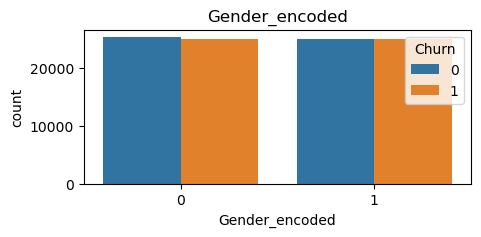

In [ ]:
plot_distribution_hue(df, ['Gender_encoded'], 'Churn')
print (df.groupby(["Gender_encoded", "Churn"]).size().reset_index(name= 'count'))

Insights from Gender_encoded (Male : 1, Female : 0)

    We can see that Female has a slightly lesser chance of churning than churning.
    The opposite is true for Male as they have a slightly higher chance of churning.

   Location_encoded  Churn  count
0                 0      0  10013
1                 0      1   9945
2                 1      0  10258
3                 1      1   9899
4                 2      0  10161
5                 2      1   9880
6                 3      0   9955
7                 3      1  10076
8                 4      0   9834
9                 4      1   9979


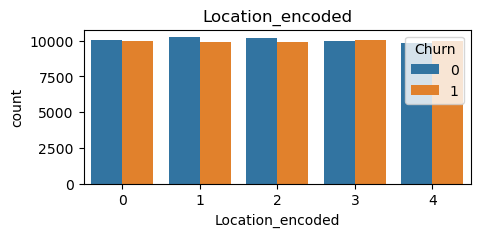

In [ ]:
plot_distribution_hue(df, ['Location_encoded'], 'Churn')
print (df.groupby(["Location_encoded", "Churn"]).size().reset_index(name= 'count'))

Insights from Location (Chicago : 0, Houston : 1, Los Angeles : 2, Miami : 3, New York: 4)

    We can see that people from Houston and Los Angeles have a lesser chance of churning which may indicate the quality of the service provided in the south of the USA. However Miami, Florida also lying in the South happens to have a higher churn.   
    Chicago and New York being in the North of the USA have higher churn, where in Chicago it's very negligible in New York it is a little more significant.

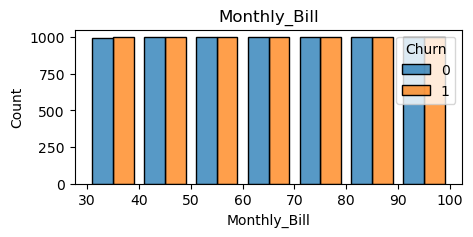

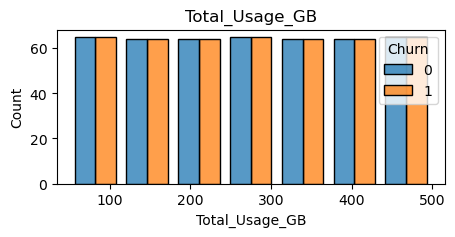

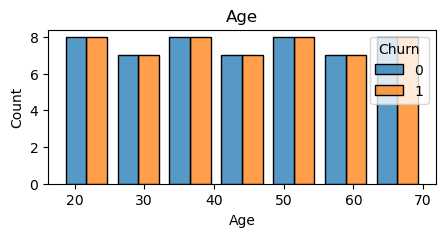

In [ ]:
histogram_distribution(df, ['Monthly_Bill'], 'Churn')
histogram_distribution(df, ['Total_Usage_GB'], 'Churn')
histogram_distribution(df, ['Age'], 'Churn')

Insights from Age, Monthly_Bill & Total_Usage_GB
  There seems to be an even distribution of

<Axes: title={'center': 'Correlation Matrix'}>

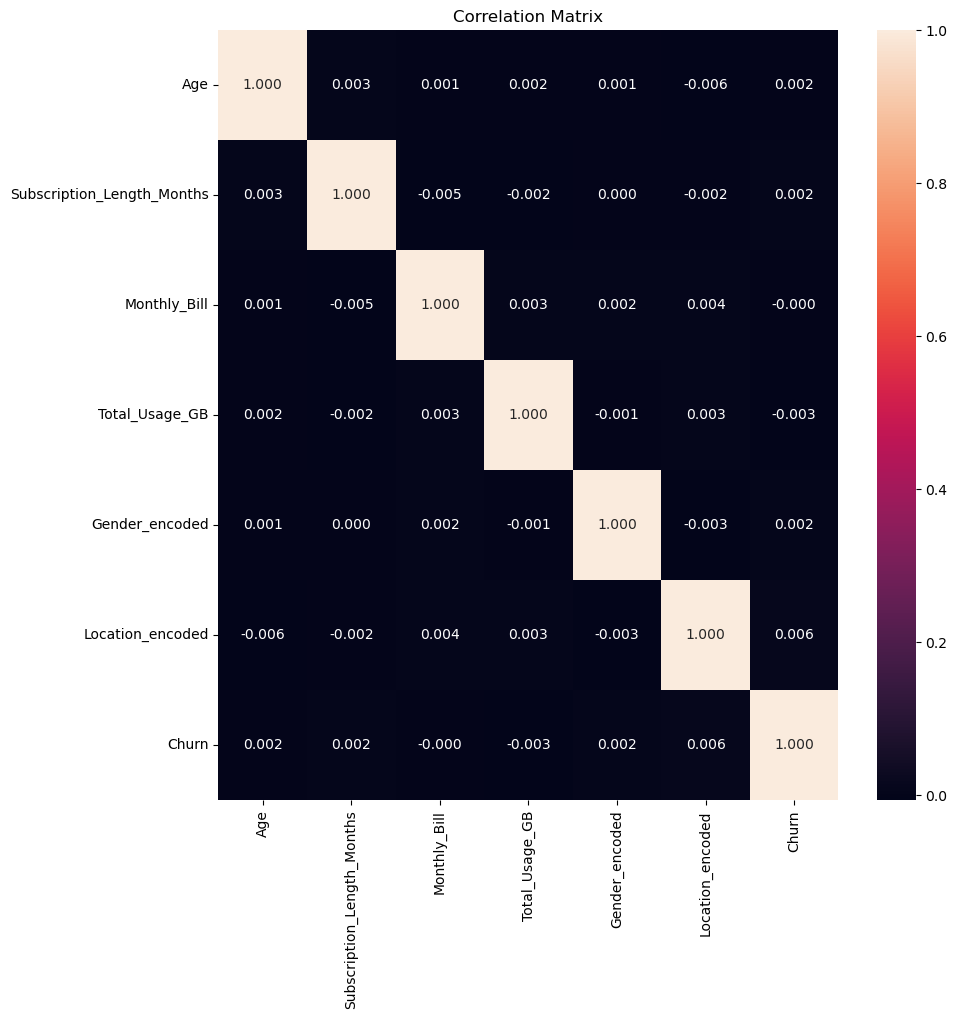

In [ ]:
corr_matrix = df.corr()
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix')
sns.heatmap(corr_matrix, annot=True, fmt=".3f")

Insights from the Correlation Matrix

    The correlation matrix shows the correlation for every feature is next to negligible, however the correlation values donot capture complex relationships between the features so we will proceed with this dataset including all the features 

In [ ]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)
print(normalized_data)
normalized_data.shape

[[0.86538462 0.69565217 0.61942857 ... 1.         0.5        0.        ]
 [0.84615385 0.         0.268      ... 0.         1.         0.        ]
 [0.11538462 0.17391304 0.79242857 ... 0.         0.5        0.        ]
 ...
 [0.88461538 0.69565217 0.94442857 ... 1.         0.         1.        ]
 [0.63461538 0.82608696 0.275      ... 0.         1.         1.        ]
 [0.17307692 0.7826087  0.66528571 ... 0.         0.5        1.        ]]


(100000, 7)

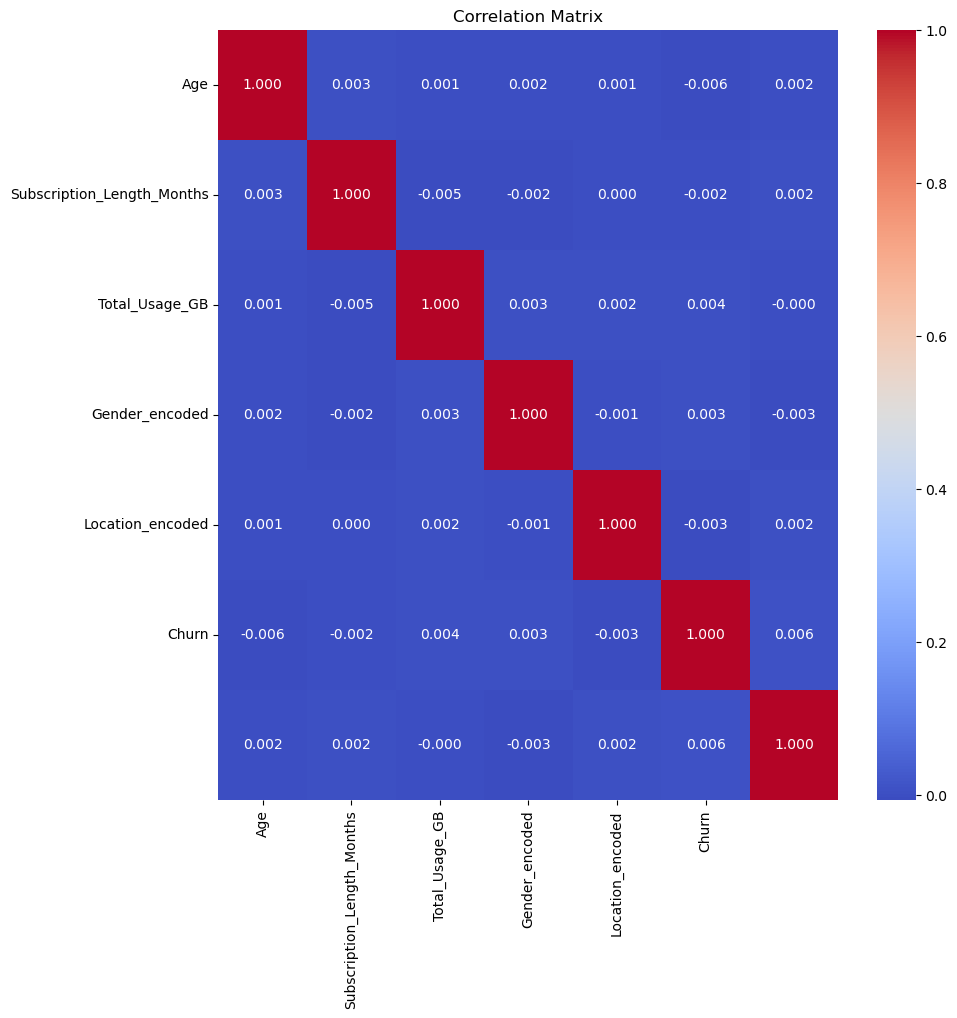

In [ ]:
corr_matrix = np.corrcoef(normalized_data, rowvar=False)

# Define feature labels
labels = ['Age', 'Subscription_Length_Months', 'Total_Usage_GB', 'Gender_encoded', 'Location_encoded', 'Churn']

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 10))
plt.title('Correlation Matrix')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.show()

In [ ]:
df["Churn"].value_counts()

0    50221
1    49779
Name: Churn, dtype: int64

# Model Training, Evaluation and Optimization

Logistic Regression using our dataframe

In [ ]:
# Step 1: Data Preparation (assuming you've already preprocessed your data)
X = df[['Age', 'Subscription_Length_Months','Total_Usage_GB', 'Monthly_Bill', 'Gender_encoded','Location_encoded']]
y = df['Churn']

# Step 2: Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Step 3: Create and Train the Model
model = LogisticRegression(max_iter=50000, random_state=42)
model.fit(X_train, y_train)

# Step 4: Model Evaluation
y_pred = model.predict(X_test)

accuracy=accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion}')
print(report)
print(f"ROC AUC Score: {roc_auc}")

Accuracy: 0.49748
Confusion Matrix:
[[7474 5128]
 [7435 4963]]
              precision    recall  f1-score   support

           0       0.50      0.59      0.54     12602
           1       0.49      0.40      0.44     12398

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.49     25000
weighted avg       0.50      0.50      0.49     25000

ROC AUC Score: 0.4966934822335306


Logistic Regression Model with our normalized data set

In [ ]:
X = normalized_data[:, :-1]  # Exclude the last column (Churn)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

logistic_regression = LogisticRegression(max_iter=5000)

logistic_regression.fit(X_train, y_train)

y_pred = logistic_regression.predict(X_test)

accuracy=accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion}')
print(report)
print(f"ROC AUC Score: {roc_auc}")

Accuracy: 0.50312
Confusion Matrix:
[[8084 4494]
 [7928 4494]]
              precision    recall  f1-score   support

           0       0.50      0.64      0.57     12578
           1       0.50      0.36      0.42     12422

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.49     25000
weighted avg       0.50      0.50      0.49     25000

ROC AUC Score: 0.5022434921562002


In [ ]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
}
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

final_model = LogisticRegression(max_iter=5000, **best_params)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Best Hyperparameters: {best_params}')
print(f'Accuracy: {accuracy}')
print(f'ROC AUC Score: {roc_auc}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{report}')


Best Hyperparameters: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.50312
ROC AUC Score: 0.5
Confusion Matrix:
[[12578     0]
 [12422     0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     12578
           1       0.00      0.00      0.00     12422

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.34     25000



D:\Me\Data Stuff\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Me\Data Stuff\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Me\Data Stuff\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Model with our dataframe

In [ ]:
X = df[[ 'Age', 'Subscription_Length_Months','Total_Usage_GB', 'Gender_encoded','Monthly_Bill', 'Location_encoded']]
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

random_forest = RandomForestClassifier(n_estimators=200, random_state=42)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

accuracy=accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion}')
print(report)
print(f"ROC AUC Score: {roc_auc}")

Accuracy: 0.49632
Confusion Matrix:
[[6465 6113]
 [6479 5943]]
              precision    recall  f1-score   support

           0       0.50      0.51      0.51     12578
           1       0.49      0.48      0.49     12422

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.50     25000
weighted avg       0.50      0.50      0.50     25000

ROC AUC Score: 0.49620902998872607


Random Forrest with our normalized dataset

In [ ]:
X = normalized_data[:, :-1]
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

random_forest = RandomForestClassifier(n_estimators=200, random_state=0)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

accuracy=accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion}')
print(report)
print(f"ROC AUC Score: {roc_auc}")

Accuracy: 0.49704
Confusion Matrix:
[[6505 6097]
 [6477 5921]]
              precision    recall  f1-score   support

           0       0.50      0.52      0.51     12602
           1       0.49      0.48      0.49     12398

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.50     25000
weighted avg       0.50      0.50      0.50     25000

ROC AUC Score: 0.49688246761723587


Decision Tree Classifier Model

In [ ]:
X = df[[ 'Age', 'Subscription_Length_Months','Total_Usage_GB', 'Gender_encoded','Monthly_Bill', 'Location_encoded']]
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

accuracy=accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion}')
print(report)
print(f"ROC AUC Score: {roc_auc}")


Accuracy: 0.49568
Confusion Matrix:
[[6246 6332]
 [6276 6146]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     12578
           1       0.49      0.49      0.49     12422

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.50     25000
weighted avg       0.50      0.50      0.50     25000

ROC AUC Score: 0.49567434036919555


Decision Tree Classification with Normalized data

In [ ]:
X = normalized_data[:, :-1]
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

accuracy=accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion}')
print(report)
print(f"ROC AUC Score: {roc_auc}")

Accuracy: 0.494
Confusion Matrix:
[[6248 6330]
 [6320 6102]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     12578
           1       0.49      0.49      0.49     12422

    accuracy                           0.49     25000
   macro avg       0.49      0.49      0.49     25000
weighted avg       0.49      0.49      0.49     25000

ROC AUC Score: 0.493982792904397


XGBoost Classification with Normalized Data

In [ ]:
X = normalized_data[:, :-1]
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

xgb_classifier = XGBClassifier(n_estimators=100, random_state=42)

xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{report}')
print(f'ROC AUC Score: {roc_auc}')

Accuracy: 0.49732
Confusion Matrix:
[[6465 6113]
 [6454 5968]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.51      0.51     12578
           1       0.49      0.48      0.49     12422

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.50     25000
weighted avg       0.50      0.50      0.50     25000

ROC AUC Score: 0.49721530917082235


# Model Serilization

In [ ]:
import os
import joblib

path ="../models/"

joblib.dump(logistic_regression, os.path.join(path, 'logistic_regression_model.pkl'))

ModuleNotFoundError: No module named 'joblib'